In [1]:
# 📦 MODULE 1: Data Loader
import pandas as pd
import json
import networkx as nx

# === Load City Grid ===
with open('city_grid.json', 'r') as f:
    city_grid = json.load(f)

# === Load Streetlights Info ===
with open('streetlights.json', 'r') as f:
    streetlights = json.load(f)

# === Load City Analysis (Optional for later use) ===
with open('city_analysis.json', 'r') as f:
    city_analysis = json.load(f)

# === Load Traffic Data ===
vehicle_log = pd.read_csv('vehicles_log_1.csv')
pedestrian_log = pd.read_csv('pedestrians_log_1.csv')

print(f"✅ Loaded {len(city_grid['nodes'])} intersections (nodes)")
print(f"✅ Loaded {len(streetlights)} streetlights")
print(f"✅ Loaded {len(vehicle_log)} vehicle records")
print(f"✅ Loaded {len(pedestrian_log)} pedestrian records")


✅ Loaded 2500 intersections (nodes)
✅ Loaded 17885 streetlights
✅ Loaded 2311767 vehicle records
✅ Loaded 3525007 pedestrian records


In [2]:
# 📦 MODULE 2: City Graph Builder
import networkx as nx

# === Initialize a Directed Graph ===
city_graph = nx.DiGraph()

# === Add Nodes (Intersections) ===
for node in city_grid['nodes']:
    city_graph.add_node(node['id'], **{
        'zone': node['zone'],
        'traffic_light': node['traffic_light'],
        'traffic_light_delay': node['traffic_light_delay']
    })

# === Add Edges (Roads) ===
# We need to add edges from city_analysis road_stats (already gives from-to info)

for road_key, road_info in city_analysis['road_stats'].items():
    # Clean the weird unicode arrow to a normal →
    if '→' in road_key:
        from_node, to_node = road_key.split('→')
    else:
        from_node, to_node = road_key.split('->')  # fallback, just in case

    city_graph.add_edge(from_node, to_node, **{
        'length_km': road_info['length_km'],
        'road_type': road_info['road_type'],
        'streetlights': road_info['streetlights'],
        'lights_per_km': road_info['lights_per_km'],
        'capacity': road_info['capacity'],
        'delay': road_info['delay']
    })

print(f"✅ Built graph with {city_graph.number_of_nodes()} nodes and {city_graph.number_of_edges()} edges")


✅ Built graph with 2500 nodes and 4900 edges


In [3]:
# 📦 MODULE 3: Hourly Traffic Analyzer
from collections import defaultdict

# === Initialize Traffic Counters ===
# Structure: traffic_counter[from_node][to_node][hour] = count
traffic_counter = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# === Helper: Parse Path into Road Segments ===
def parse_path(path_str):
    """Convert 'A1→A2→A3' into [('A1', 'A2'), ('A2', 'A3')]"""
    nodes = path_str.split('→')
    return list(zip(nodes[:-1], nodes[1:]))

# === Process Vehicle Logs ===
for _, row in vehicle_log.iterrows():
    path_segments = parse_path(row['path'])
    hour = row['hour']
    for from_node, to_node in path_segments:
        traffic_counter[from_node][to_node][hour] += 1  # vehicle adds 1

# === Process Pedestrian Logs ===
for _, row in pedestrian_log.iterrows():
    path_segments = parse_path(row['path'])
    hour = row['hour']
    for from_node, to_node in path_segments:
        traffic_counter[from_node][to_node][hour] += 1  # pedestrian also adds 1

print("✅ Aggregated traffic for all roads per hour!")


✅ Aggregated traffic for all roads per hour!


In [4]:
traffic_counter['A1']['A2'][0]  # Traffic from A1 to A2 during 0th hour


11

In [5]:
# 📦 MODULE 4: Traffic-to-Voltage Optimizer
import numpy as np

# === Parameters you can tweak ===
MIN_VOLTAGE = 20  # Minimum voltage even if 0 traffic
MAX_VOLTAGE = 100  # Maximum voltage at max traffic
TRAFFIC_THRESHOLD = 100  # If traffic >= this, max voltage is given

# === Initialize voltage schedule ===
# Structure: voltage_schedule[from_node][to_node][hour] = voltage
voltage_schedule = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

# === Calculate Voltage per Road per Hour ===
for from_node in traffic_counter:
    for to_node in traffic_counter[from_node]:
        for hour in list(range(19, 24)) + list(range(0, 7)):  # assuming 0-23 hours
            traffic = traffic_counter[from_node][to_node].get(hour, 0)
            # Normalize traffic to voltage
            if traffic >= TRAFFIC_THRESHOLD:
                voltage = MAX_VOLTAGE
            else:
                voltage = MIN_VOLTAGE + (traffic / TRAFFIC_THRESHOLD) * (MAX_VOLTAGE - MIN_VOLTAGE)
            voltage_schedule[from_node][to_node][hour] = round(voltage, 2)

print("✅ Voltage optimization complete!")


✅ Voltage optimization complete!


In [6]:
voltage_schedule['A1']['A2'][0]


28.8

In [7]:
# 📦 MODULE 5: Smart Voltage Smoother
def smooth_voltages(voltage_schedule, smoothing_factor=0.6):
    """Smooths sudden jumps in voltage using simple weighted average."""
    smoothed_schedule = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    
    for from_node in voltage_schedule:
        for to_node in voltage_schedule[from_node]:
            prev_voltage = None
            for hour in list(range(19, 24)) + list(range(0, 7)):
                current_voltage = voltage_schedule[from_node][to_node][hour]
                
                if prev_voltage is None:
                    smoothed_voltage = current_voltage
                else:
                    smoothed_voltage = (smoothing_factor * prev_voltage) + ((1 - smoothing_factor) * current_voltage)
                
                smoothed_schedule[from_node][to_node][hour] = round(smoothed_voltage, 2)
                prev_voltage = smoothed_voltage  # update for next hour
                
    return smoothed_schedule

# === Apply smoothing
smoothed_voltage_schedule = smooth_voltages(voltage_schedule)

print("✅ Voltage smoothing complete!")


✅ Voltage smoothing complete!


In [8]:
smoothed_voltage_schedule['A1']['A2'][0]


39.45

In [9]:
# 📦 MODULE 6A: Voltage Scheduler Exporter (Save to JSON)
import json

# === Export smoothed voltage schedule to a JSON file ===
def export_voltage_schedule(smoothed_schedule, filename='smoothed_voltage_schedule.json'):
    with open(filename, 'w') as f:
        json.dump(smoothed_schedule, f, indent=4)
    print(f"✅ Voltage schedule exported to {filename}")

# === Run Export Function ===
export_voltage_schedule(smoothed_voltage_schedule)


✅ Voltage schedule exported to smoothed_voltage_schedule.json


In [10]:
# traffic_data_generator.ipynb

import pandas as pd
import json

# Load the vehicle and pedestrian log data
vehicle_log = pd.read_csv('vehicles_log_1.csv')
pedestrian_log = pd.read_csv('pedestrians_log_1.csv')

# Function to create a traffic data dictionary
def generate_traffic_data(vehicle_log, pedestrian_log):
    # Initialize an empty dictionary to hold the traffic data
    traffic_data = {}

    # Process vehicle data
    for _, row in vehicle_log.iterrows():
        from_intersection = row['from']
        to_intersection = row['to']
        hour = row['hour']
        
        # Initialize dictionary for the intersection pair if not already created
        if from_intersection not in traffic_data:
            traffic_data[from_intersection] = {}
        if to_intersection not in traffic_data:
            traffic_data[to_intersection] = {}
        
        # Initialize traffic counts for each hour if not already created
        if hour not in traffic_data[from_intersection]:
            traffic_data[from_intersection][hour] = {'vehicle': 0, 'pedestrian': 0}
        if hour not in traffic_data[to_intersection]:
            traffic_data[to_intersection][hour] = {'vehicle': 0, 'pedestrian': 0}
        
        # Increment vehicle traffic count
        traffic_data[from_intersection][hour]['vehicle'] += 1
        traffic_data[to_intersection][hour]['vehicle'] += 1

    # Process pedestrian data
    for _, row in pedestrian_log.iterrows():
        from_intersection = row['from']
        to_intersection = row['to']
        hour = row['hour']
        
        # Initialize traffic counts for each hour if not already created
        if hour not in traffic_data[from_intersection]:
            traffic_data[from_intersection][hour] = {'vehicle': 0, 'pedestrian': 0}
        if hour not in traffic_data[to_intersection]:
            traffic_data[to_intersection][hour] = {'vehicle': 0, 'pedestrian': 0}
        
        # Increment pedestrian traffic count
        traffic_data[from_intersection][hour]['pedestrian'] += 1
        traffic_data[to_intersection][hour]['pedestrian'] += 1

    return traffic_data

# Generate the traffic data
traffic_data = generate_traffic_data(vehicle_log, pedestrian_log)

# Export traffic data to a JSON file
with open('traffic_data.json', 'w') as f:
    json.dump(traffic_data, f, indent=4)

print("✅ traffic_data.json has been generated successfully!")


✅ traffic_data.json has been generated successfully!


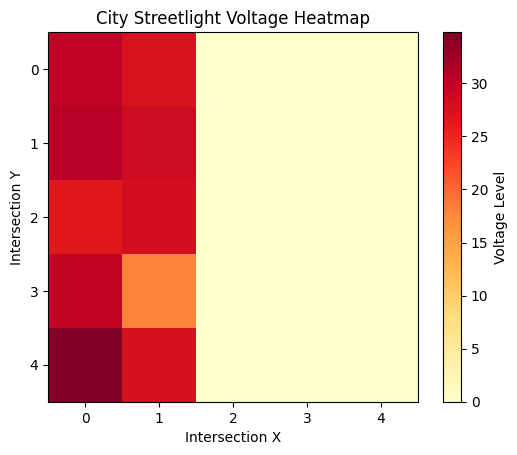

In [11]:
# 📦 MODULE 6B: City Light Heatmap Visualizer
import matplotlib.pyplot as plt
import numpy as np

# === Helper: Create a grid for the heatmap ===
def create_voltage_heatmap(smoothed_schedule, grid_size=(5, 5)):
    # Create a dummy 5x5 city grid (You could scale this later)
    voltage_grid = np.zeros(grid_size)
    
    # Populate the grid with average voltage for each intersection
    for i, from_node in enumerate(smoothed_schedule):
        for j, to_node in enumerate(smoothed_schedule[from_node]):
            # Take the average voltage for each road pair
            avg_voltage = np.mean([smoothed_schedule[from_node][to_node][hour] for hour in range(24)])
            voltage_grid[i % grid_size[0]][j % grid_size[1]] = avg_voltage
    
    return voltage_grid

# === Plot Heatmap ===
def plot_heatmap(voltage_grid):
    plt.imshow(voltage_grid, cmap='YlOrRd', interpolation='nearest')
    plt.colorbar(label='Voltage Level')
    plt.title("City Streetlight Voltage Heatmap")
    plt.xlabel("Intersection X")
    plt.ylabel("Intersection Y")
    plt.show()

# === Generate and Plot Heatmap ===
voltage_grid = create_voltage_heatmap(smoothed_voltage_schedule)
plot_heatmap(voltage_grid)
